# Brain atrophy as Potential Biomarker of Alzheimer's disease in Aged Sample

Count: 2087


# Introduction

Dementia is a progressive condition associated with brain atrophy and aging, involving widespread neuropsychological deficits that significantly hinder daily activities (Reuben et. al, 2010). Our project focuses on Alzheimer's disease (AD), the most common form of dementia. Unfortunately, AD has neither definitive diagnosis nor cure (Ash, 2007). Consequently, the early detection and prevention of AD by examining signs such as shrinkage in brain matter is essential for healthy aging.

The current paper hypothesizes that patients with Alzheimer’s Disease will have significantly lower mean total brain volume compared to non-Alzheimer’s disease patients above the age of 60. We will not perform hypothesis testings on scale parameters (e.g., standard deviation) as we do not intend to examine the difference in variation between the two groups.

We analyze the dataset _Dementia Classification: Compare Classifiers_ from Kaggle.com (Deepak N, 2018), estimating the population mean difference and the variability of the sampling distribution in a series of exploratory data analysis before hypothesis testing. Our null-hypothesis states that there is no difference between the two groups. If we observe a significantly lower brain volume, similar neuro-imaging techniques may be applicable for detecting early signs of AD in clinical settings.

The current dataset originally comes from the MRI Open Access Series of Imaging Studies (OASIS-2, 2009) which collects patient information using magnetic resonance imaging to investigate possible biomarkers of AD. This dataset consists of 15 variables and 373 rows, sampling from 150 participants of age 60-96 longitudinally. It characterizes whether participants have AD or not (coded `Demented` and `Nondemented`). The following table summarizes the data variables:


<img src=https://raw.githubusercontent.com/yuwangy/alzheimer_analysis/main/Variable_descriptors.png width="1000">


Table 1.1: Description of data set variables. (Variables of interst are bolded.)



$µ_a$ = Mean normalized whole brain volume (nWBV) patients exhibiting signs of **Alzheimer’s disease**.

$µ_n$ = Mean normalized whole brain volume (nWBV) of patients **not** exhibiting signs of Alzheimer’s disease

$H_0$: $µ_n - µ_a = 0$

$H_1$: $µ_n - µ_a > 0$


## Methods and Results

### Preliminary Exploratory Analysis

Start analysis by loading the required libraries, reading the CSV file into a data frame, and preview the data frame.

In [43]:
library(dplyr)
library(readr)
library(tidyverse)
library(cowplot)
library(datateachr)
library(infer)
library(repr)
library(digest)
library(gridExtra)
library(broom)

data_alzheimer <- read.csv("https://raw.githubusercontent.com/yuwangy/alzheimer_analysis/main/oasis_longitudinal.csv")

head(data_alzheimer)


,Subject.ID,MRI.ID,Group,Visit,MR.Delay,M.F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<int>,<int>,<int>,<int>,<dbl>,<int>,<dbl>,<dbl>
1,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2,27,0.0,1987,0.696,0.883
2,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2,30,0.0,2004,0.681,0.876
3,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NA,23,0.5,1678,0.736,1.046
4,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,NA,28,0.5,1738,0.713,1.010
5,OAS2_0002,OAS2_0002_MR3,Demented,3,1895,M,R,80,12,NA,22,0.5,1698,0.701,1.034
6,OAS2_0004,OAS2_0004_MR1,Nondemented,1,0,F,R,88,18,3,28,0.0,1215,0.710,1.444



Table 1.2: Loaded data set



Clean and wrangle the data into tidy format for planned analysis. The current number of observations is 336 because each patients had at least multiple laboratory visits:

1. Filter only demented and nondemented patients in `Group`
2. Remove missing NA values from `nWBV`
3. Select variable of interest: `Group` and `nWBV` columns, along with `Subject.ID`

In [44]:
nwbv_tidy <- data_alzheimer |>
filter(Group == "Demented" | Group == "Nondemented") |>
filter(!is.na(nWBV)) |>
select(Subject.ID, Group, nWBV)

# Count number of rows of filtered data: 336
nrow(nwbv_tidy)

# Preview data:
head(nwbv_tidy)


[1] 336

,Subject.ID,Group,nWBV
,<chr>,<chr>,<dbl>
1,OAS2_0001,Nondemented,0.696
2,OAS2_0001,Nondemented,0.681
3,OAS2_0002,Demented,0.736
4,OAS2_0002,Demented,0.713
5,OAS2_0002,Demented,0.701
6,OAS2_0004,Nondemented,0.710


Table 1.3 : Tidy data

Count individual participants as the sample size after NA values are removed:

In [45]:
total_sample_size <- nwbv_tidy|>
group_by(Subject.ID)|>
summarize(count = n()) |>
nrow()

total_sample_size # n = 136

[1] 136

Because this longitudinal data with each patient getting multiple brain-scans and `nWBV` estimates, we average each patient's `nWBV`. We validate the correct number of observations with the sample size(n=136):


In [46]:
nwbv <- nwbv_tidy |>
group_by(Group, Subject.ID) |>
summarize(nWBV = mean(nWBV))

nrow(nwbv) # n = 136

head(nwbv)


`summarise()` has grouped output by 'Group'. You can override using the
`.groups` argument.


[1] 136

Group,Subject.ID,nWBV
<chr>,<chr>,<dbl>
Demented,OAS2_0002,0.7166667
Demented,OAS2_0007,0.7283333
Demented,OAS2_0009,0.7985000
Demented,OAS2_0010,0.7605000
Demented,OAS2_0014,0.6965000
Demented,OAS2_0016,0.6530000


Table 1.4: Preview of average longitudinal nWBV estimates of each participant

Visualize differences between the `Demented` and `Nondemented` in their nWBV measure using boxplot: 

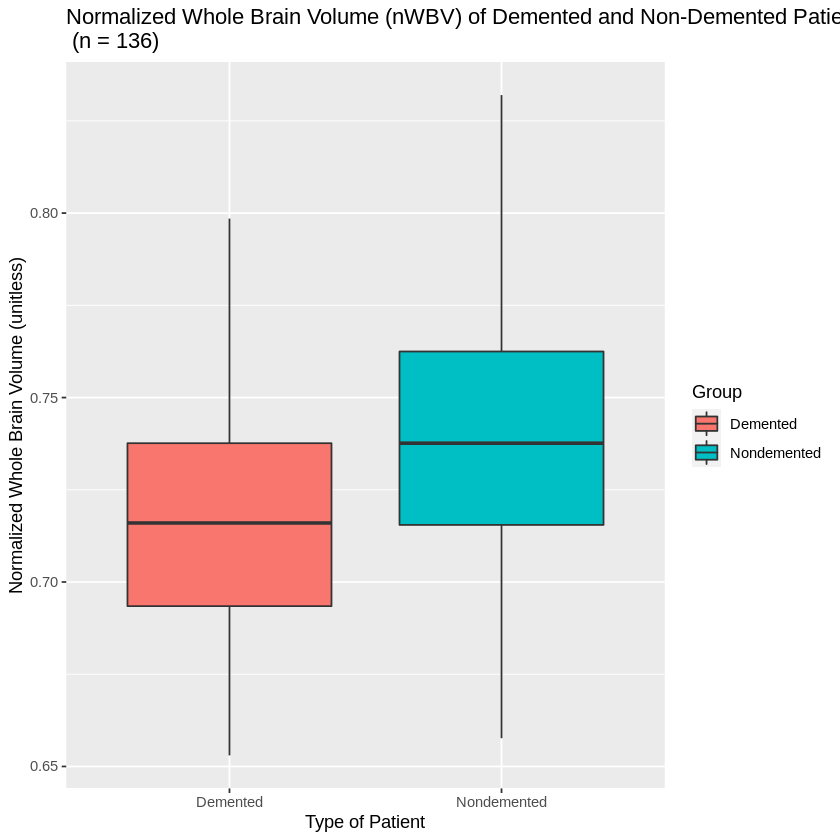

In [47]:
boxplot_nwbv <- nwbv |>
ggplot() +
geom_boxplot(aes(x = Group, y = nWBV, fill = Group)) +
xlab("Type of Patient") + 
ylab("Normalized Whole Brain Volume (unitless)") +
ggtitle("Normalized Whole Brain Volume (nWBV) of Demented and Non-Demented Patients \n (n = 136)")

boxplot_nwbv

Figure 1.0: Boxplot normalized whole brain volumne (nWBV) measure between Nondemented vs. Demented

> The `Nondemented` group appears to have a higher median line than the `Demented` group, suggesting that healthy participants tend to have greater brain volume than those who exhibit signs of Alzheimer's disease.

### Descriptive Summary
Calculate descriptive summary of the observed data that is relevant to the planned analysis:
1. Sample mean of nWBV of each group
2. Sample size of each group
3. Sample standard deviation of each group


In [48]:
nWBV_descriptive <- nwbv |>
                    group_by(Group) |>
                    summarize(mean = mean(nWBV),
                              sample_size = n(), 
                              sd = sd(nWBV))

nWBV_descriptive

Group,mean,sample_size,sd
<chr>,<dbl>,<int>,<dbl>
Demented,0.7175107,64,0.03172100
Nondemented,0.7404854,72,0.03811823


Table 1.5:  Descriptive statistic for Demented and Nondemented groups

Compute sample mean nWBV difference between `Nondemented` and `Demented`:

In [49]:
sample_diff_in_mean <- nWBV_descriptive |> 
                        summarize(sample_diff_in_mean = mean[2] - mean[1])

sample_diff_in_mean

sample_diff_in_mean
<dbl>
0.02297474


Table 1.6: Sample mean difference between Nondemented and Demented groups ($\bar X_n - \bar X_a$)

> `Demented` participants has a mean measure of nWBV of 0.718 and a standard deviation of 0.032 ($n_a = 64$). `Nondemented` participants has a mean nWBV of 0.740 and a standard deviation of 0.038 ($n_n = 72$). The mean `nWBV` difference ($\bar X_n - \bar X_a$) is 0.0230, indicating a slightly higher brain volume in sampled healthy seniors than Alzheimer's patients.  

### Bootstrapping: Estimate the Sampling Distribution of Each Group
Generate bootstrapping samples of each group to estimate their sampling distributions and standard error.

In [50]:
#set seed for data reproducibility
set.seed(2365)

bootstrap_demented_infer <- nwbv |>
filter(Group == "Demented") |>
specify(response = nWBV) |>
generate(reps = 2000, type = "bootstrap") |>
calculate(stat = "mean")

se_bootstrap_demented_infer <- bootstrap_demented_infer |>
summarise(Demented_mean = mean(stat),
          standard_error = sd(stat))

se_bootstrap_demented_infer


Demented_mean,standard_error
<dbl>,<dbl>
0.7174911,0.003871272


Table 1.7: Bootstrap mean and standard error of `Demeneted` 

In [51]:
bootstrap_nondemented_infer <- nwbv |>
filter(Group == "Nondemented") |>
specify(response = nWBV) |>
generate(reps = 2000, type = "bootstrap") |>
calculate(stat = "mean")

se_bootstrap_nondemented_infer <- bootstrap_nondemented_infer |>
summarise(Nondemented_mean = mean(stat),
          standard_error = sd(stat))

se_bootstrap_nondemented_infer

Nondemented_mean,standard_error
<dbl>,<dbl>
0.7404034,0.004435305


Table 1.8: Bootstrap mean and standard error of `Nondemeneted`

>Perform bootstrap resample for each group (reps = 2000), we estimate the standard error of the sampling distribution of the `Demented` group as 0.004 and the `Nondemented` group as 0.004. Both bootstrap means of the Demented ($\bar X_a=0.717$) and Nondemented ($\bar X_n=0.740$) group center at the sample group mean.

### Mean Difference -- The Parameter of Interest
Find the observed sample mean difference between `Nondemented` and `Demented` using the `infer` package. 


In [63]:
obs_diff_in_means <-
                nwbv |>
                specify(formula = nWBV ~ Group) |>
                calculate(stat = "diff in means", order = c("Nondemented", "Demented")) 

obs_diff_in_means

stat
<dbl>
0.02297474


Table 1.9: Oberserved Difference in mean, consistent with `sample_diff_in_mean` from descriptive summary

### Bootstrap to Estimate the Sampling Distribution of Mean Difference

Construct the bootstrapping distribution for the mean `nWBV` difference between the two groups:

In [64]:
#set seed
set.seed(5830) 

nwbv_diff_in_means_bootstrap <- nwbv |>
                            specify(formula = nWBV ~ Group) |>
                            generate(reps = 2000, type = "bootstrap") |>
                            calculate(stat = "diff in means", order = c("Nondemented", "Demented"))

head(nwbv_diff_in_means_bootstrap)


replicate,stat
<int>,<dbl>
1,0.02884483
2,0.02363775
3,0.02052829
4,0.02197534
5,0.02296906
6,0.01920900


Table 1.10: bootstrap resample 

In [65]:
nwbv_diff_in_means_bootstrap |>
summarize(se = sd(stat))

se
<dbl>
0.005956585


Table 1.11: Standard error of the bootstrap resample 

>The bootstrap resample of mean difference between Nondemented and Demented approximates a standard error of 0.006.

Visualize the bootstrap distribution of mean difference:


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



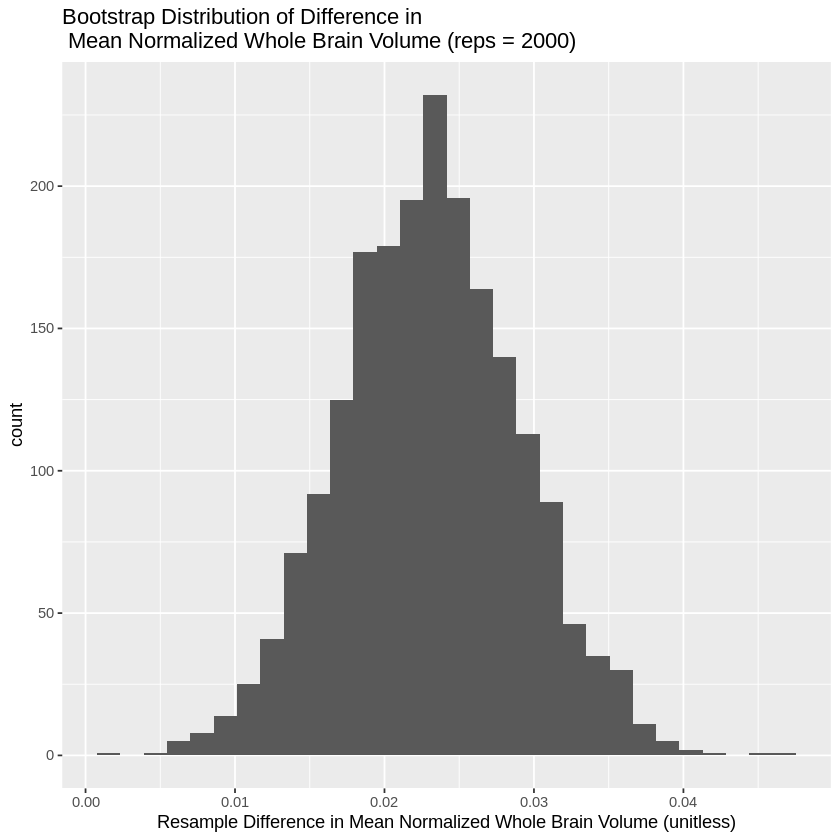

In [55]:
nwbv_diff_in_means_boot_dis <- nwbv_diff_in_means_bootstrap |>
        ggplot(aes(x = stat)) + 
        geom_histogram() +
        labs(x = "Resample Difference in Mean Normalized Whole Brain Volume (unitless)", 
             title = "Bootstrap Distribution of Difference in \n Mean Normalized Whole Brain Volume (reps = 2000)")

nwbv_diff_in_means_boot_dis

Figure 1.1: Bootstrap distribution of Mean `nWBV` Difference between `Nondemented` and `Demented` groups

## Hypothesis Testing: 

In the previous boxplot, we saw that the `Nondemented` group ($\bar X_n = 0.740$) has a slightly higher nWBV measures than the `Demented` group ($\bar X_a = 0.718$), where the observed mean difference ($\bar X_n - \bar X_a$) is 0.023. However, we need to have statistical evidence to better investigate whether such group differences in their brain volume estimate are meaningful significant or merely random. 

To answer our question, we perform hypothesis testing to analyze this apparent difference. As mentioned, we expected to see nondemented patients to show significantly greater brain volume estimates compared to Alzheimer's patients. 

Because we have no access to the population information (i.e., population standard deviation) of all Alzheimer's patients of  age ≥ 60, we perform an **asymptotic Independence Group's t-test**, using the sample standard deviation ($s$) in place of the population standard deviation ($\sigma$). We assume normality and independence in the data due to the relatively large sample size (n=136) and that the onset of Alzheimer's disease among participants likely does not influence one another.

Additionally, we perform an **simulation-based test** to model the null distribution using permutation resampling. We also construct a confidence interval (CI) for both estimating the plausible range of true mean differences to examine whether it agrees with the previous tests. Based on convention in the field, we set the significance level to **⍺ = 0.05 (one-tailed)** for the hypothesis testing and the confidence level to 95%.


#### Asymptotic: Independence Group's t-test

Assign total sample size, group size, group standard deviation, and observed mean difference to numeric objects to clarify steps during later tests.

In [100]:
nWBV_descriptive # review the descriptive statistic


Group,mean,sample_size,sd
<chr>,<dbl>,<int>,<dbl>
Demented,0.7175107,64,0.03172100
Nondemented,0.7404854,72,0.03811823


Table 1.13: Review of the descriptive summary table

In [102]:
n_total <- nWBV_descriptive$sample_size[1] + nWBV_descriptive$sample_size[2]
n_total

n_demented <- nWBV_descriptive$sample_size[1]
n_demented

n_nondemented <- nWBV_descriptive$sample_size[2]
n_nondemented

sd_demented <- nWBV_descriptive$sd[1]
sd_demented

sd_nondemented <- nWBV_descriptive$sd[2]
sd_nondemented

obs_diff_in_means
obs_diff_in_means <- obs_diff_in_means |>
                      as.numeric()


[1] 136

[1] 64

[1] 72

[1] 0.031721

[1] 0.03811823

[1] 0.02297474

To perform two-samples t-test comparing the means of two independent samples($\bar X_n - \bar X_a$), the functions `pt()` and `t.test()` can be used to obtain p-value and validate each another:

1. Compute the standard error using group standard deviations.
2. Compute t statistics

><img src=https://raw.githubusercontent.com/yuwangy/alzheimer_analysis/main/Welch-t-testequationandDegreeofFreedom(WS8).png width="800">

3. Compute p-value using `pt()` in the upper tail (since the observed mean difference is positive).


In [90]:
# t.test()
# t_stat <- (obs difference - µ0)/SE

SE <- sqrt(sd_nondemented^2/n_nondemented + sd_demented^2/n_demented)
SE

t_stat <- (obs_diff_in_means - 0)/SE
t_stat

df <- (sd_nondemented^2/n_nondemented + sd_demented^2/n_demented)^2 / ((sd_nondemented^4)/(n_nondemented^2*(n_nondemented-1)) + (sd_demented^4/(n_demented^2*(n_demented-1))))
df

[1] 0.005991892

[1] 3.834305

[1] 133.4433

In [89]:
pt(t_stat, df = df, lower.tail = FALSE)

[1] 9.664187e-05

Create a vector of `nWBV` values of each group:

In [88]:
nondemented_nwbv <- nwbv |>
                    filter(Group == "Nondemented")
head(nondemented_nwbv)

demented_nwbv <- nwbv |>
                 filter(Group == "Demented")
head(demented_nwbv)

Group,Subject.ID,nWBV
<chr>,<chr>,<dbl>
Nondemented,OAS2_0001,0.6885000
Nondemented,OAS2_0004,0.7140000
Nondemented,OAS2_0005,0.7093333
Nondemented,OAS2_0008,0.7005000
Nondemented,OAS2_0012,0.7346667
Nondemented,OAS2_0013,0.7150000


Group,Subject.ID,nWBV
<chr>,<chr>,<dbl>
Demented,OAS2_0002,0.7166667
Demented,OAS2_0007,0.7283333
Demented,OAS2_0009,0.7985000
Demented,OAS2_0010,0.7605000
Demented,OAS2_0014,0.6965000
Demented,OAS2_0016,0.6530000


Table 2.0: filtered dataframe of only `Nondemented` patients.

Table 2.1: filtered dataframe of only `Demented` patients.

Place `Nondemented` and then `Demented` into `t.test()`. The $H_1$ argues that the mean `nWBV` difference between `Nondemented` and then `Demented` is positive, so we use `alternative = "greater"`.

In [87]:
t.test(nondemented_nwbv$nWBV, demented_nwbv$nWBV, alternative = "greater") |>
        tidy()

estimate,estimate1,estimate2,statistic,p.value,parameter,conf.low,conf.high,method,alternative
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
0.02297474,0.7404854,0.7175107,3.834305,9.664187e-05,133.4433,0.01305005,Inf,Welch Two Sample t-test,greater


Table 2.2: Tidy t-test summary table

>Both t-tests computes _p_ = 9.664e-05. Since _p_ < 0.05, we can reject the $H_0$ that there is no difference between the two groups in their Normalized Whole Brain Volume (nWBV) estimate. 

>The positive t-statistic 3.834 suggests that the nWBV estimate of the Nondemented group is greater than that of the Demented group, giving support in favor of $H_1$.

#### Permutation: Hypothesis Testing Through Permutation Resampling

Construct the null distribution of mean difference using permutation avaliable in the infer package:
1. Set seed.
2. Specify explanatory variable `Group` and dependent variable `nWBV`.
3. Hypothesize null-hypothesis involving independent group difference.
4. Generate null-distribution using permutation with 1000 replicates.
5. Calculate the statistic of interest: mean nWBV difference between `Nondemented` and `Demented`.

In [91]:
set.seed(4392) 

nwbv_null_distribution <- nwbv |>
specify(formula = nWBV ~ Group) |>
hypothesize(null = "independence") |>
generate(reps = 1000, type = "permute") |>
calculate(stat = "diff in means", order = c("Nondemented", "Demented"))

head(nwbv_null_distribution)


replicate,stat
<int>,<dbl>
1,-0.0041445891
2,-0.0082179977
3,0.0009229456
4,-0.0029374711
5,-0.0050939525
6,0.0019244502


Table 2.3: Permuted null distribution 

Compute the observed difference nWBV mean value between Nondemented and Demented to (1) get the p-value and (2) visualize the observed mean difference on the permutated null-distribution:


In [94]:
obs_diff_mean <- nwbv |>
specify(formula = nWBV ~ Group) |>
calculate(stat = "diff in means", order = c("Nondemented", "Demented"))

obs_diff_mean

stat
<dbl>
0.02297474


Table 2.4:  Difference in mean nWBV value between the two groups 

In [96]:
nwbv_null_distribution |>
get_p_value(obs_stat = obs_diff_mean, direction = "right")

Warning message:
“Please be cautious in reporting a p-value of 0. This result is an approximation based on the number of `reps` chosen in the `generate()` step. See `?get_p_value()` for more information.”


p_value
<dbl>
0


Table 2.5:  p-value of observed mean difference under permutaion $H_0$

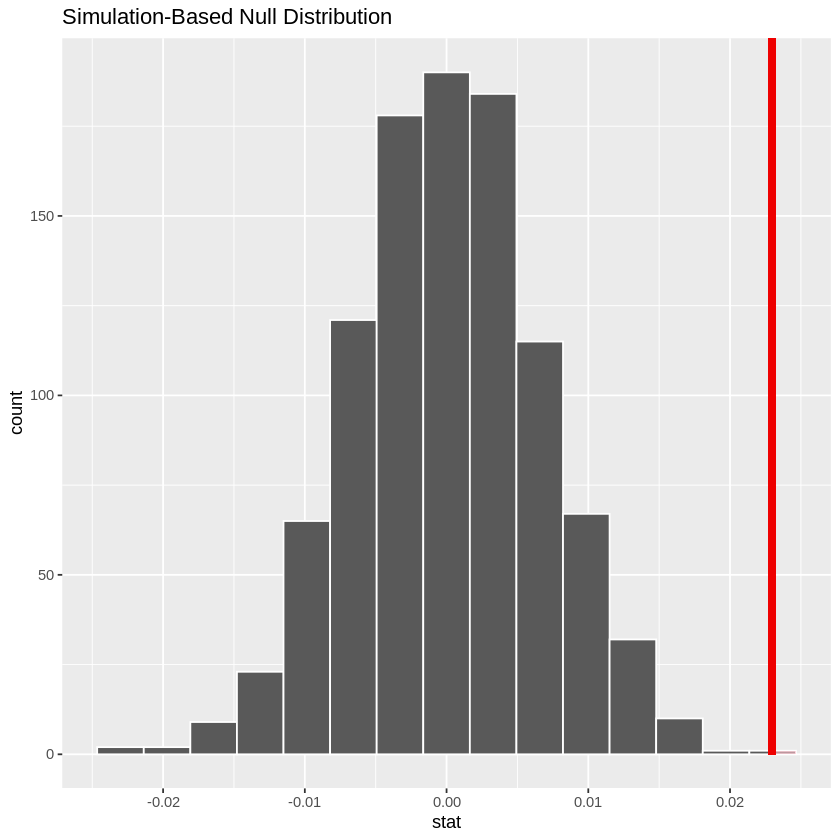

In [60]:
# visualize the null distribution and the p-value
visualize(nwbv_null_distribution) + 
shade_p_value(obs_stat = obs_diff_mean, direction = "right")

Figure 2.0: Visualization of the null distribution 

>Using the simulated-based permutation test of 1000 samples, the p-value computes 0. We cannot report a p-value of 0 as it means there is no possibility of creating a type-I error. The best claim we can make would be **_p_ < 0.001** when reps = 1000. 

>This is consistent with the previous decision made in the theory-based test, as we also reject the $H_0$ that there is no group difference in the Normalized Whole Brain Volume measures (nWBV) between Nondemented and Demented patients. The Nondemented group seems to have greater nWBV estimate than the demented group.

### Parameter Estimation using Bootstrap & Confidence Interval (CI)
In the preliminary data analysis, we bootstrapped the difference of means between the Nondemented and Demented group. We can apply this bootstrap resample to construct a 95% confidence interval.

Confidence interval estimates the range of plausible values of means difference in the true population based on our bootstrap sample. A 95%CI indicates that over repeated samplings, 95% of samples will capture the true population mean difference. **This means we can also use CI to validate the decisions we made in previous tests: If the 95%CI includes the mean difference of no effect ($\mu_n - \mu_a$ = 0), this suggests that repeated sampling will contain the null 95% of times, which is analogous to failing to reject the null-hypothesis under $\alpha = 0.05$. Hence, we expect the 95%CI to not capture the value of 0**:

Find the 95% confidence interval for the bootstrapped means difference from `nwbv_diff_in_means_bootstrap`:


In [105]:
diff_in_means_ci <- nwbv_diff_in_means_bootstrap |>
                get_confidence_interval(level = 0.95, type = "percentile")

diff_in_means_ci

lower_ci,upper_ci
<dbl>,<dbl>
0.01150707,0.03516066


Table 3.0: The bootstrap 95% confidence interval 95%CI:(0.012, 0.035)

Shade the 95%CI on the bootstrap distribution:

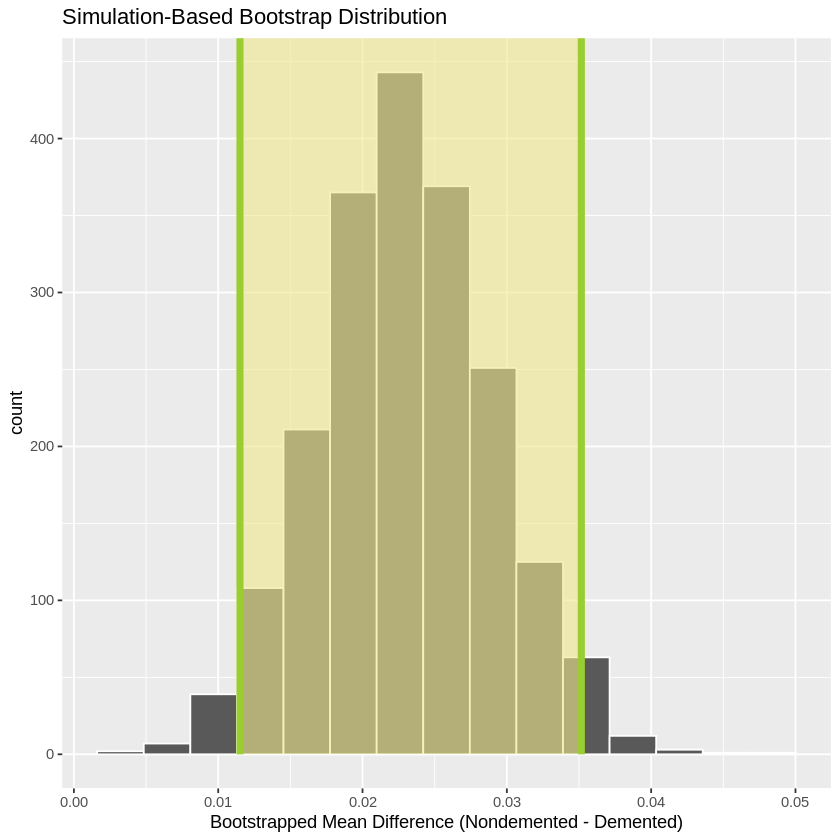

In [62]:
visualize(nwbv_diff_in_means_bootstrap) + 
  shade_confidence_interval(endpoints = diff_in_means_ci, fill = "khaki", color = "yellowgreen") +
  xlab("Bootstrapped Mean Difference (Nondemented - Demented)")

Figure 2.1: Visualization of nWBV bootstrap resample mean difference

>We obtain 95%CI(0.012, 0.035), which indicates that over repeated samples, 95% of confidence intervals constructed in the same manner will capture the true parameter $µ_n - µ_a$. 

>Since this interval does not capture the null-effect value $µ_n - µ_a$ = 0, we can reject the null hypothesis. This decision is consistent with the previous conclusions made in the independent group's t-test and simulation-based test.

## Discussion

The present dataset includes longitudinal patient (age 60-95) information of normalized whole brain volume (nWBV) of individuals with and without indications of Alzheimer’s Disease (AD, denoted `Nondemented` and `Demented`). We eliminated participants with empty nWBV values and took the average nWBV estimates across different laboratory visits for each participant. 


In the exploratory data analysis, we observed a slight difference of nWBV between the Demented and Nondemented group. The Nondemented group showed larger nWBV estimates ($\bar X_{n} - \bar X_{a}$ = 0.0230). Using bootstrap to estimate the sampling distribution, the standard error is approximately SE = 0.006. We are interested in investigating whether this difference is significantly different by performing hypothesis testing using both theory-based and simulation-based permutation tests. We hypothesized that aged patients categorized as non-Alzheimer’s will show significantly more brain volume than Alzheimer’s patients. We set the significance level to $\alpha$ = 0.05(one-tail) based on convention in the field.


We performed the Independent Group’s t-test and permutation test, and we calculated a t-statistics of 3.834 while obtaining the p-values: _p_ = 9.664e-05 (t-tests). Using permutation, we obtained _p_ < 0.001. Since each p-value was less than 0.05, we rejected the $H_0$ that there is no difference in normalized whole brain volume between non-AD and AD patients. Our results seem to be in favor of the alternative hypothesis that non-AD aged patients tend to show higher brain volumes. The confidence level approach of hypothesis testing agreed with these results, as the 95%CI (0.017, 0.320) does not capture the mean-difference value 0 that indicates no effect.


Our conclusions agreed with our expectation that patients with signs of AD would have a significantly lower normalized whole brain volume than the non-demented group, as previous studies have suggested brain atrophy using confirmatory post-mortem autopsy and neuroimaging scans on Alzheimer's and demented patients (Reuben et. al, 2011; Nedelska et. al, 2015).


Considering the observed significant brain volume difference between the two groups in this data, our inferential analysis suggests that brain atrophy can be used as an important biomarker to identify, examine, and mitigate the onset of Alzheimer’s Disease among the aged population. This positive finding replicates results of many previous studies (Domoto-Reilly et. al, 2012, Sabuncu et. al, 2011), consistent with our previous expectation.

Critically, the present results make the case for applying neuroimaging to help advance healthcare to detect early signs of Alzheimer’s disease when there is no definitive diagnosis for Alzheimer’s, a devastating disease that can completely eradicate one’s knowledge of the world,their loved ones, and their very self. The current finding also leads to additional questions about other neurodegenerative diseases as to whether similar kinds of neuroimaging assessment can further shed light on their treatment and prevention.


# References

Ash, L. E. (2007). Dementia. On Call Series: On Call Neurology (3rd ed., pp. 401-417), W.B. Saunders.

Dickerson, B. C., Bakkour, A., Salat, D. H., Feczko, E., Pacheco, J., Greve, D. N., Grodstein, F., Wright, C. I., Blacker, D., Rosas, H. D., Sperling, R. A., Atri, A., Growdon, J. H., Hyman, B. T., Morris, J. C., Fischl, B., & Buckner, R. L. (2009). The cortical signature of Alzheimer's disease: regionally specific cortical thinning relates to symptom severity in very mild to mild AD dementia and is detectable in asymptomatic amyloid-positive individuals. Cerebral cortex (New York, N.Y. : 1991), 19(3), 497–510. https://doi.org/10.1093/cercor/bhn113 

Deepak N. (2018). Dementia Classification :Compare Classifiers: Python · MRI and Alzheimers. Kaggle. https://www.kaggle.com/code/deepak525/dementia-classification-compare-classifiers/input

Nedelska, Z., Ferman, T. J., Boeve, B. F., Przybelski, S. A., Lesnick, T. G., Murray, M. E., Gunter, J. L., Senjem, M. L., Vemuri, P., Smith, G. E., Geda, Y. E., Graff-Radford, J., Knopman, D. S., Petersen, R. C., Parisi, J. E., Dickson, D. W., Jack, C. R., Jr, & Kantarci, K. (2015). Pattern of brain atrophy rates in autopsy-confirmed dementia with Lewy bodies. Neurobiology of aging, 36(1), 452–461. https://doi.org/10.1016/j.neurobiolaging.2014.07.005

OASIS-2: Longitudinal. (2009). Open Access Series of Imaging Studies. https://doi.org/10.1162/jocn.2009.21407



Reuben, A., Brickman, A., Muraskin, J., Steffener, J., & Stern, Y. (2011). Hippocampal Atrophy Relates to Fluid Intelligence Decline in the Elderly. Journal of the International Neuropsychological Society, 17(1), 56-61. https://doi.org/10.1017/S135561771000127X

Sabuncu, M. R., Desikan, R. S., Sepulcre, J., Yeo, B. T., Liu, H., Schmansky, N. J., Reuter, M., Weiner, M. W., Buckner, R. L., Sperling, R. A., Fischl, B., & Alzheimer's Disease Neuroimaging Initiative (2011). The dynamics of cortical and hippocampal atrophy in Alzheimer disease. Archives of neurology, 68(8), 1040–1048. https://doi.org/10.1001/archneurol.2011.167

